In [34]:
# Import modules and subroutines:

include("../subroutines/Subroutines.jl");

3.10.9


In [13]:
# Load the chemical data into julia as an array of chemical data structs:
# (one struct obtained for each molecular geometry as set up in the config file)

cdata_list = ReadIn("../datasets/pyscf_data/h2o_sto-3g_080222%000756.hdf5");
chemical_data = cdata_list[1]
PrintChemData(chemical_data)

Molecule name: h2o
Basis set: sto-3g
Molecular geometry: O 0.0 0.0 0.0; H 1.0 0.0 0.0; H 0.0 1.0 0.0; 
RHF energy: -74.96117113786774
FCI energy: -75.01927599660624


In [14]:
# Run a DMRG calculation to get the excited states:

dmrg1 = GenSubspace(chemical_data, 20, psi_maxdim=7, sweep_num=10, sweep_noise=(1e-6, 1e-7, 1e-8, 0.0));
dmrg1.ord_list = [collect(1:dmrg1.chem_data.N_spt) for j=1:dmrg1.mparams.M]
GenStates!(dmrg1, verbose=true, ovlp_opt=true, weight=1.0, denseify=false);

GenPermOps!(dmrg1)

GenSubspaceMats!(dmrg1, verbose=true)

display(dmrg1.S_mat)

biparts = []
entrops = []

for j=1:dmrg1.mparams.M
    biparts_j, entrops_j = ComputeBipartites(dmrg1, state=j)
    push!(biparts, biparts_j)
    push!(entrops, entrops_j)
end



Generating states:
Progress: [20/20] 
Done!


20×20 Matrix{Float64}:
  1.0           9.48223e-6   -0.000331801  …  -0.00970142   -1.12933e-6
  9.48223e-6    1.0          -0.00202505      -0.019769      4.9958e-6
 -0.000331801  -0.00202505    1.0             -0.0140618    -1.03801e-5
  0.00763391    0.000112995   0.00451729      -0.0127405    -6.17648e-6
 -0.000493047  -0.017334     -0.00198337       0.0150196    -5.04256e-6
  6.78467e-5   -0.00259946    0.0202538    …  -0.00297401   -3.07769e-5
 -0.00111686    0.00107897    0.0107147       -0.00487683    2.11095e-6
 -4.00657e-11   2.93641e-7   -8.41036e-7      -0.000102333   0.000711405
  2.09891e-5    0.00229733   -0.00333201      -0.000309483  -0.00203043
 -6.38127e-7    7.74033e-6   -9.02306e-6       0.000103042   0.0083732
  0.000658079  -0.0685128     0.0168097    …   0.00233557   -0.000360943
  0.975329      0.00492489    0.00137397      -0.0119062    -0.000358896
  1.32563e-5   -0.000133768   3.83315e-5       0.000194365  -0.00566327
 -0.0154811    -0.0202837     0.00032801

In [48]:
fixed_zeta = [0.03, 0.38, 0.48, 0.4, 0.53, 
              0.25, 0.28, 0.25, 0.4, 0.16,
              0.52, 0.08, 0.33, 0.36, 0.36,
              0.42, 0.63, 0.8, 0.24, 0.38]

tnqe0 = GenSubspace(chemical_data, 5, psi_maxdim=3, sweep_num=6, sweep_noise=(1e-6), thresh="projection", eps=1e-12);

pops = []

gp = GeomParameters(
    costfunc = "composite",
    zeta_list = fixed_zeta
)


for k=1:5
    
    new_ords = BipartiteAnnealing(
        [randperm(tnqe0.chem_data.N_spt) for j=1:tnqe0.mparams.M], 
        biparts, 
        entrops, 
        tnqe0.mparams.psi_maxdim,
        gp,
        verbose=true
    )
    
    println("")
    
    for i=1:8
        push!(pops, new_ords)
    end
    
end

tnqe0.ord_list = BipartiteGenetics(
    tnqe0.mparams.M,
    tnqe0.chem_data.N_spt,
    biparts, 
    entrops, 
    tnqe0.mparams.psi_maxdim,
    gp,
    pop_in=pops,
    verbose=true
);

0.47882804667040296    
0.4869395284543449    
0.5016083102846063    
0.47684329564759836    
0.49003272987378504    


In [49]:
# Initialize the states:
opt_sweeps = Sweeps(15)
maxdim!(opt_sweeps,tnqe0.mparams.psi_maxdim)
mindim!(opt_sweeps,tnqe0.mparams.psi_maxdim)
cutoff!(opt_sweeps,1e-12)
setnoise!(opt_sweeps, 1e-1,1e-1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-8,1e-10,1e-12,0.0)

#GenStates!(tnqe0, sweeps=opt_sweeps, verbose=true);
lev_list = collect(1:tnqe0.mparams.M)
#levs = reverse(collect(1:tnqe1.mparams.M))
#levs = randperm(tnqe1.mparams.M)
GenExcited!(tnqe0, sweeps=opt_sweeps, weight = 2.0, levs=lev_list, verbose=true);

Generating states:
Progress: [1/1] 
Done!
Generating states:
Progress: [2/2] 
Done!
Generating states:
Progress: [3/3] 
Done!
Generating states:
Progress: [4/4] 
Done!
Generating states:
Progress: [5/5] 
Done!


EXCITATION LEVEL: 0


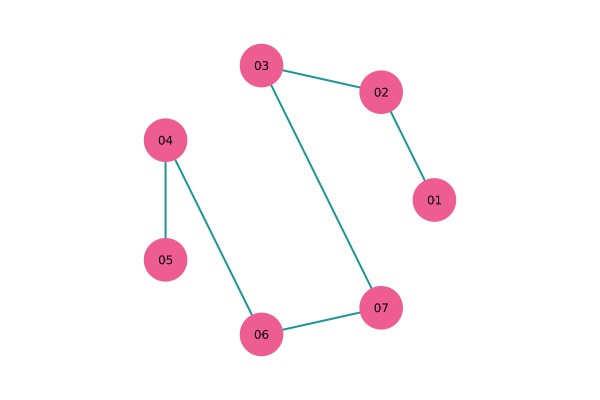

EXCITATION LEVEL: 1


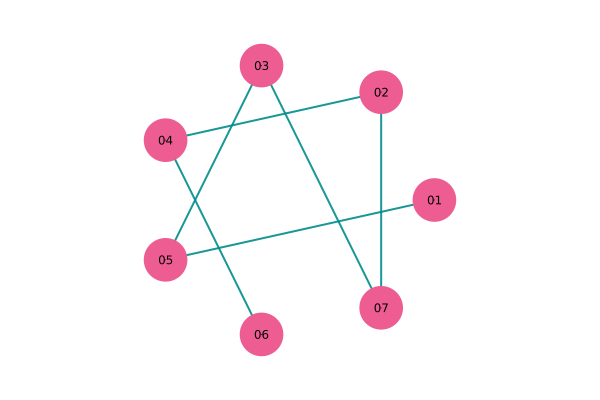

EXCITATION LEVEL: 2


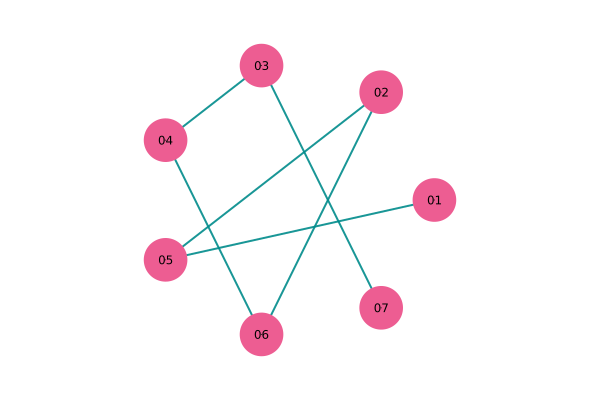

EXCITATION LEVEL: 3


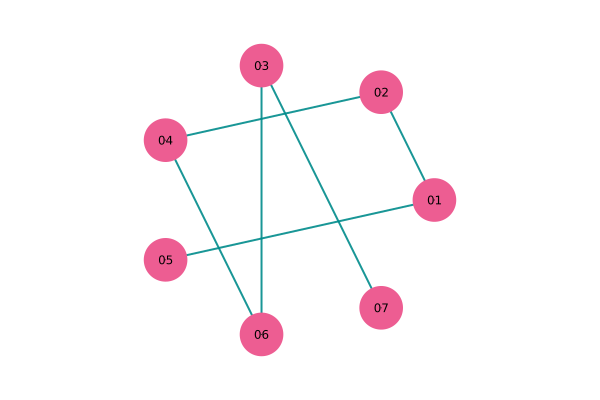

EXCITATION LEVEL: 4


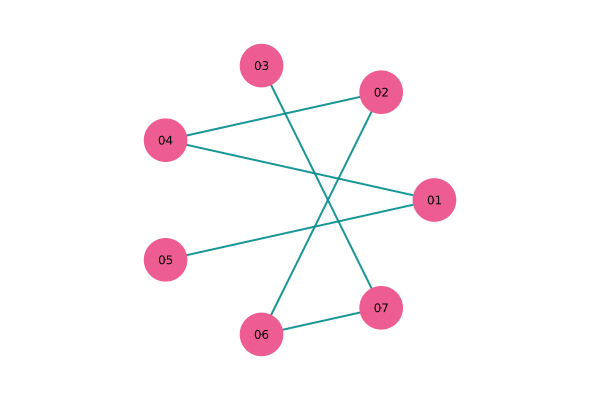

In [50]:
graph_mat_list = []

for (j,ord) in enumerate(tnqe0.ord_list)
    push!(graph_mat_list, GraphMat(ord, directed=false) )
end

for j=1:length(graph_mat_list)
    println("EXCITATION LEVEL: $(j-1)")
    OrbitalGraphPlot(graph_mat_list[j], multiplier=2.0)
end

In [51]:
#using Profile
#using ProfileVega

#Profile.clear()

tnqe1 = copy(tnqe0);
GenPermOps!(tnqe1, no_rev=false, verbose=false);
GenSubspaceMats!(tnqe1, verbose=false);
SolveGenEig!(tnqe1, thresh="inversion", eps=1e-8, verbose=false);


op1 = OptimParameters(
    maxiter=15, 
    numloop=15, 
    noise=[0.0], 
    sd_thresh="inversion", 
    sd_eps=1.0e-6,
    afunc="exp",
    alpha=2e4,
    restrict_svals=false,
    sweep=false,
    rnoise=1e-3,
    delta=1e-6
)

op2 = OptimParameters(
    maxiter=1, 
    numloop=18, 
    noise=[1e-6], 
    sd_thresh="inversion", 
    sd_eps=1.0e-6,
    afunc="flat",
    alpha=2e4,
    restrict_svals=true,
    sweep=true,
    delta=0.0,
    rnum=0
)

RandomSiteDecomp!(
    tnqe1, 
    op1, 
    verbose=true
)

RandomSiteDecomp!(
    tnqe1, 
    op2, 
    verbose=true
)


RANDOM SITE DECOMPOSITION:
Iter: 15/15; loop: 15/15; E_min = -83.85654; kappa = 1.26; E_best = -83.85978; accept = 10/14 (71%)     
Done!


RANDOM SITE DECOMPOSITION:
Iter: 1/1; loop: 18/18; E_min = -83.85992; kappa = 5.31; E_best = -83.85978; accept = 0/0 (0%)     
Done!



Minimum eigenvalue: -83.85991666358322
Condition number: 5.314261563772072
FCI energy: -75.01927599660624
Final energy estimate: -75.0188964945723
Best single ref. estimate: -74.99078864836753
Error: 0.00037950203393677384
BSRfE: 0.028487348238712684
Improvement: 0.02810784620477591
Percentage error reduction: 98.66782253386066
Eigenvalue condition numbers: [0.0121, 0.0125, 0.0302, 0.0254, 0.0199]
Percent correlation energy with single-geometry DMRG: 50.9725195840881
Percent correlation energy with multi-geometry TNQE: 99.34686695368335


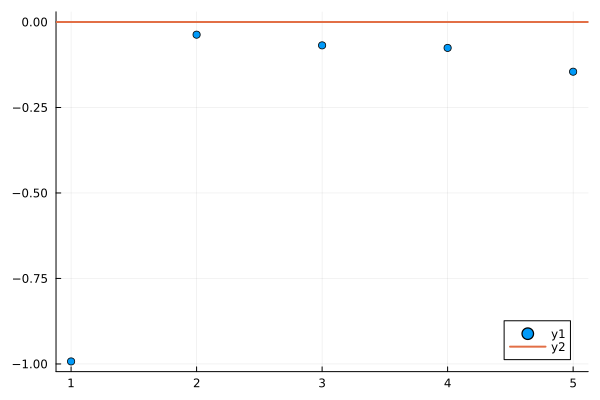

In [52]:
SolveGenEig!(tnqe1, thresh="none", verbose=true)